In [58]:
import pylab
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
data_df = pd.read_csv('./data.csv')
data_df['game_date'] = data_df['game_date'].apply(lambda x: pd.to_datetime(x))
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

In [59]:
# Remove unnecessary columns
#data_df = data_df.drop(columns=['combined_shot_type', 'game_event_id', 'game_id', 'lat', 'lon', 'shot_type', 'shot_zone_range', 'team_id', 'team_name'])
preprocess_df = data_df[['action_type', 'loc_x', 'loc_y', 'period', 'playoffs', 'shot_distance', 'shot_made_flag', 'shot_zone_area', 'shot_zone_basic', 'opponent']]

In [61]:
# Feature preprocessing
preprocess_df = pd.get_dummies(preprocess_df, prefix_sep=':', columns=['action_type', 'shot_zone_area', 'shot_zone_basic', 'opponent'])
preprocess_df['season'] = data_df['season'].apply(lambda x: int(x[0:4])-1996)

preprocess_df['matchup'] = data_df['matchup'].apply(lambda x: 0 if "@" in x else 1)

preprocess_df['time_remaining'] = (data_df['minutes_remaining']*60) + data_df['seconds_remaining']

min_dates = pd.DataFrame(data_df, columns=['game_date'])
min_date = min_dates.min()
preprocess_df['game_date'] = data_df['game_date'].apply(lambda x: (x - min_date).dt.days)
preprocess_df

,loc_x,loc_y,period,playoffs,shot_distance,shot_made_flag,action_type:Alley Oop Dunk Shot,action_type:Alley Oop Layup shot,action_type:Cutting Finger Roll Layup Shot,action_type:Cutting Layup Shot,...,opponent:SAS,opponent:SEA,opponent:TOR,opponent:UTA,opponent:VAN,opponent:WAS,season,matchup,time_remaining,game_date
0,167,72,1,0,18,NaN,0,0,0,0,...,0,0,0,0,0,0,4,0,627,1458
1,-157,0,1,0,15,0.0,0,0,0,0,...,0,0,0,0,0,0,4,0,622,1458
2,-101,135,1,0,16,1.0,0,0,0,0,...,0,0,0,0,0,0,4,0,465,1458
3,138,175,1,0,22,0.0,0,0,0,0,...,0,0,0,0,0,0,4,0,412,1458
4,0,0,2,0,0,1.0,0,0,0,0,...,0,0,0,0,0,0,4,0,379,1458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,1,48,4,1,4,0.0,0,0,0,0,...,0,0,0,0,0,0,3,1,365,1324
30693,0,0,4,1,0,NaN,0,0,0,0,...,0,0,0,0,0,0,3,1,365,1324
30694,-134,166,4,1,21,1.0,0,0,0,0,...,0,0,0,0,0,0,3,1,208,1324
30695,31,267,4,1,26,0.0,0,0,0,0,...,0,0,0,0,0,0,3,1,130,1324


In [62]:
# object_features = []

# for column in data_df:
#     if isinstance(data_df[column][0], str):
#         object_features.append(data_df[column].name)

# allFeatures = {}

# for feature in object_features:
#     uniques = data_df[feature].unique()
#     categories_to_index = {}

#     for counter in range(len(uniques)):
#         categories_to_index[uniques[counter]] = counter

#     allFeatures[feature] = categories_to_index

# data_df.replace(allFeatures, inplace=True)

In [64]:
# Standardize the features
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
standardize_exclude = ['game_date']
for column in preprocess_df:
    if column not in standardize_exclude:
        # data_df[column] = StandardScaler().fit_transform(data_df[column].values.reshape(-1,1))
        preprocess_df[column] = MinMaxScaler().fit_transform(preprocess_df[column].values.reshape(-1,1))

In [65]:
preprocess_df = preprocess_df.dropna()
preprocess_df.to_csv("preprocessed.csv", index=False)

In [9]:
train_df = data_df[data_df.apply(lambda x: not pd.isnull(x.shot_made_flag), axis=1)]
test_df = data_df[data_df.apply(lambda x: pd.isnull(x.shot_made_flag), axis=1)]

In [10]:
# from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

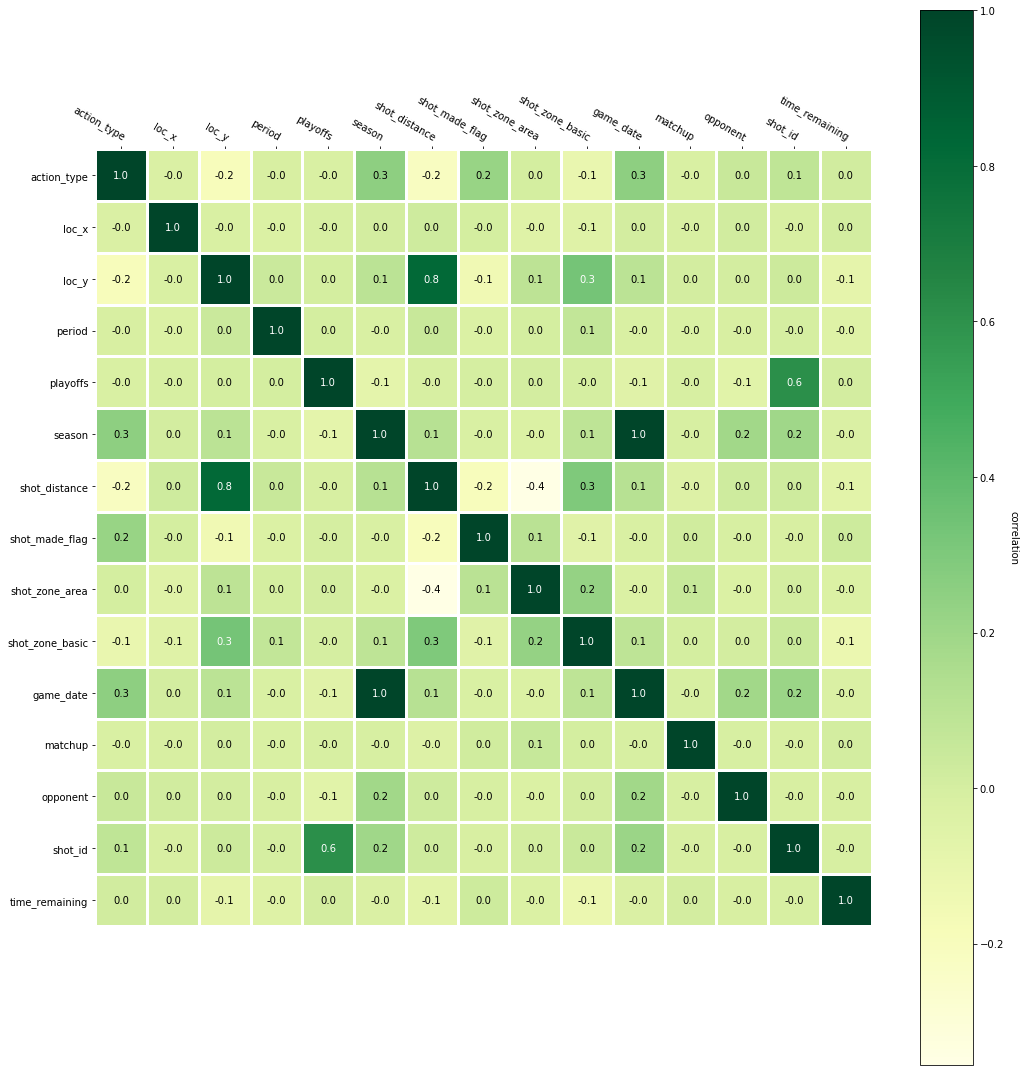

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

im, cbar = heatmap(train_df.corr(), train_df.columns, train_df.columns, ax=ax,
                   cmap="YlGn", cbarlabel="correlation")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()